In [19]:
#veri okuma işleme
import cv2
import urllib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random, os, glob
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen
#  model değerlendirme
from sklearn.metrics import confusion_matrix, classification_report


In [20]:
#colab ile drive bağlama
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
dir_path='/content/drive/MyDrive/Garbage classification'

In [22]:
#Target size ve label etiket değerlerinin belirlenmesi
target_size=(224,224)
waste_labels={'cardboard':0,'glass':1,'metal':2,'paper':3,'plastic':4,'trash':5}

In [23]:

def load_datasets(path, target_size=(128, 128)):  # Default target size
    """
    Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur.

    Parametreler:
    path: Görsellerin bulunduğu dizin
    target_size: Görüntülerin yeniden boyutlandırılacağı hedef boyut (Genişlik, Yükseklik)

    Dönüş:
    x: Görüntü matrislerini içeren NumPy dizisi
    labels: Görüntü etiketlerini içeren NumPy dizisi
    """
    x = []
    labels = []

    img_paths = sorted(list(paths.list_images(path)))

    if not img_paths:
        print("Error: No images found in the given directory!")
        return None, None

    for image_path in img_paths:
        img = cv2.imread(image_path)

        if img is None:
            print(f"Warning: Could not read image {image_path}")
            continue

        img = cv2.resize(img, target_size)

        x.append(img)

        label = image_path.split(os.path.sep)[-2]

        if label not in waste_labels:
            print(f"Warning: Label '{label}' not found in waste_labels.")
            continue

        labels.append(waste_labels[label])

    # Convert to NumPy array for better performance
    x = np.array(x, dtype=np.uint8)
    labels = np.array(labels)

    # Shuffle dataset
    x, labels = shuffle(x, labels, random_state=42)

    print(f"x boyutu: {x.shape}")
    print(f"Label sınıf sayısı: {len(np.unique(labels))}, Gözlem sayısı: {len(labels)}")

    return x, labels


In [24]:
x,labels=load_datasets(dir_path)

x boyutu: (3200, 128, 128, 3)
Label sınıf sayısı: 6, Gözlem sayısı: 3200


In [25]:
input_shape = (np.array(x[0]).shape[1],np.array(x[0]).shape[1],3)
print(input_shape)

(128, 128, 3)


In [26]:
def visualize_img(img_batch,label_batch):
  """
  Veri seti içerisinden görüntü görselleştirir.
  parametreler:
  img_batch görüntülere ait matris
  label_batch görüntünün ait olduğu sınıf bilgisini tutan liste
  """

  plt.figure(figsize=(10,10))
  for n in range(10):
    ax=plt.subplot(5,5,n+1)
    plt.imshow(img_batch)
    plt.title(np.array(list(waste_labels.keys())))[to_categorical(labels,num_classes=6)[n]==1][0].title()
    plt.axis('off')


VERİYİ HAZIRLAMA

In [28]:
#Train veri seti için bir generatır tanımlıyoruz
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range=0.1,
                         zoom_range=0.1,
                         width_shift_range=0.1,
                         height_shift_range=0.1)

#Test veri seti için bir generator tanımlıyoruz
test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)



In [29]:
train_generator=train.flow_from_directory(directory=dir_path,
                                          target_size=(target_size),
                                          class_mode='categorical',
                                          subset="training")
test_generator=test.flow_from_directory(directory=dir_path,
                                        target_size=(target_size),
                                        batch_size=251,
                                        class_mode='categorical',
                                        subset='validation')

Found 2882 images belonging to 7 classes.
Found 318 images belonging to 7 classes.


Sıfırdan CNN Modeli Kurma

- sequential
- Evrişim katmanı (convolution layer,Conv2D)
- Havuzlama Katmanı (Pooling Layer)
- Aktivasyon Fonksiyonu Katmanı (Activation Layer)
- Flattening Katmanı
- Dense Katmanı
- Dropout Katmanı

In [30]:
from tensorflow.keras.layers import GlobalAveragePooling2D
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

# 🔹 Flatten yerine GlobalAveragePooling2D() kullanıyoruz
model.add(GlobalAveragePooling2D())  # Bu, çıkış boyutunu küçültür

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=7, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,279 (165.15 KB)

 Trainable params: 42,279 (165.15 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
#Optimizasyon ve değerlendirme metriklerinin ayarlanması
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[Precision(), Recall(), 'accuracy']
)

callbacks=[EarlyStopping(monitor='val_loss',patience=50,verbose=1,mode='min'),
           ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',save_best_only=True,save_weights_only=False,verbose=1)]




In [32]:
#Model eğitme
import tensorflow as tf
print(tf.__version__)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=callbacks,
    steps_per_epoch=2276 // 32,
    validation_steps=251 // 32
)

2.18.0


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.1644 - loss: 1.9267 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.86236, saving model to mymodel.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


71/71 ━━━━━━━━━━━━━━━━━━━━ 53s 632ms/step - accuracy: 0.1647 - loss: 1.9265 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.3050 - val_loss: 1.8624 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/10
20/71 ━━━━━━━━━━━━━━━━━━━━ 28s 566ms/step - accuracy: 0.2047 - loss: 1.8743 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 2: val_loss did not improve from 1.86236
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - accuracy: 0.2143 - loss: 1.8731 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.1887 - val_loss: 1.8644 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.2112 - loss: 1.8775 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 3: val_loss improved from 1.86236 to 1.82372, saving model to mymodel.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 534ms/step - accuracy: 0.2112 - loss: 1.8774 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.3050 - val_loss: 1.8237 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/10
20/71 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step - accuracy: 0.1990 - loss: 1.8330 - precision_2: 0.0458 - recall_2: 2.4717e-04
Epoch 4: val_loss improved from 1.82372 to 1.74458, saving model to mymodel.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.2166 - loss: 1.8143 - precision_2: 0.1925 - recall_2: 0.0012 - val_accuracy: 0.2673 - val_loss: 1.7446 - val_precision_2: 0.5000 - val_recall_2: 0.0031
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.2325 - loss: 1.7817 - precision_2: 0.4376 - recall_2: 0.0162
Epoch 5: val_loss improved from 1.74458 to 1.71399, saving model to mymodel.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 69s 506ms/step - accuracy: 0.2327 - loss: 1.7813 - precision_2: 0.4374 - recall_2: 0.0163 - val_accuracy: 0.2704 - val_loss: 1.7140 - val_precision_2: 0.5000 - val_recall_2: 0.0031
Epoch 6/10
20/71 ━━━━━━━━━━━━━━━━━━━━ 25s 494ms/step - accuracy: 0.2545 - loss: 1.6949 - precision_2: 0.5206 - recall_2: 0.0409
Epoch 6: val_loss improved from 1.71399 to 1.70194, saving model to mymodel.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.2569 - loss: 1.7128 - precision_2: 0.4982 - recall_2: 0.0373 - val_accuracy: 0.2956 - val_loss: 1.7019 - val_precision_2: 0.5000 - val_recall_2: 0.0063
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.3025 - loss: 1.7024 - precision_2: 0.4510 - recall_2: 0.0310
Epoch 7: val_loss improved from 1.70194 to 1.68274, saving model to mymodel.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 490ms/step - accuracy: 0.3024 - loss: 1.7025 - precision_2: 0.4515 - recall_2: 0.0310 - val_accuracy: 0.2767 - val_loss: 1.6827 - val_precision_2: 0.5000 - val_recall_2: 0.0031
Epoch 8/10
20/71 ━━━━━━━━━━━━━━━━━━━━ 21s 418ms/step - accuracy: 0.2723 - loss: 1.7269 - precision_2: 0.2482 - recall_2: 0.0159
Epoch 8: val_loss did not improve from 1.68274
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.2911 - loss: 1.6965 - precision_2: 0.3417 - recall_2: 0.0202 - val_accuracy: 0.2610 - val_loss: 1.7604 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.3371 - loss: 1.6545 - precision_2: 0.6017 - recall_2: 0.0492
Epoch 9: val_loss improved from 1.68274 to 1.64804, saving model to mymodel.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 73s 503ms/step - accuracy: 0.3371 - loss: 1.6544 - precision_2: 0.6012 - recall_2: 0.0493 - val_accuracy: 0.2610 - val_loss: 1.6480 - val_precision_2: 0.4630 - val_recall_2: 0.0786
Epoch 10/10
20/71 ━━━━━━━━━━━━━━━━━━━━ 23s 468ms/step - accuracy: 0.3175 - loss: 1.6283 - precision_2: 0.4950 - recall_2: 0.0753
Epoch 10: val_loss improved from 1.64804 to 1.58699, saving model to mymodel.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.3139 - loss: 1.6276 - precision_2: 0.4904 - recall_2: 0.0695 - val_accuracy: 0.3082 - val_loss: 1.5870 - val_precision_2: 0.4848 - val_recall_2: 0.0503


Text(0.5, 1.0, 'Training and Validation loss')

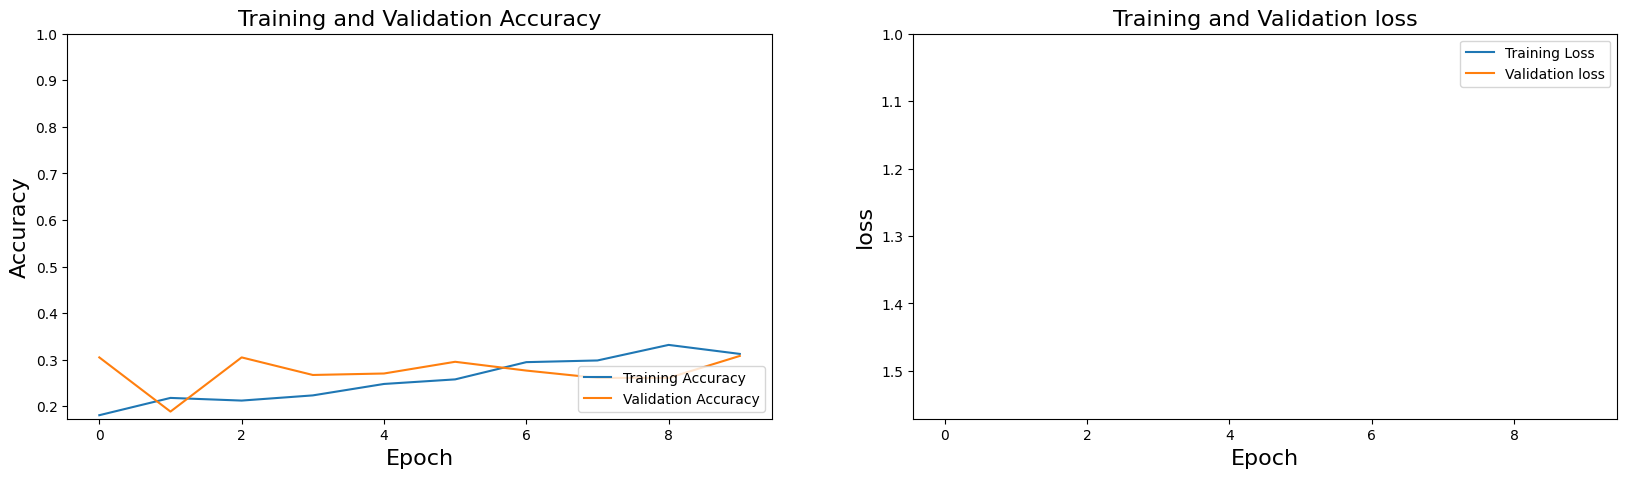

In [35]:
#Accuracy grafiği

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontsize=16)

#Loss Grafiği

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation loss',fontsize=16)

In [38]:
#Değerlendirme
loss,precision,recall,acc=model.evaluate(test_generator,batch_size=32)
print("\n Test accuracy: %.lf%%"%(100.0*acc))
print("\n Test loss: %.lf%%"%(100.0*loss))
print("\n Test precision: %.lf%%"%(100.0*precision))
print("\n Test recall: %.lf%%"%(100.0*recall))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.3037 - loss: 1.5987 - precision_2: 0.4899 - recall_2: 0.0495

 Test accuracy: 31%

 Test loss: 159%

 Test precision: 48%

 Test recall: 5%


In [40]:
#Classification Report
x_test,y_test=next(test_generator)

y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
y_test=np.argmax(y_test,axis=1)

target_names=list(waste_labels.keys())

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


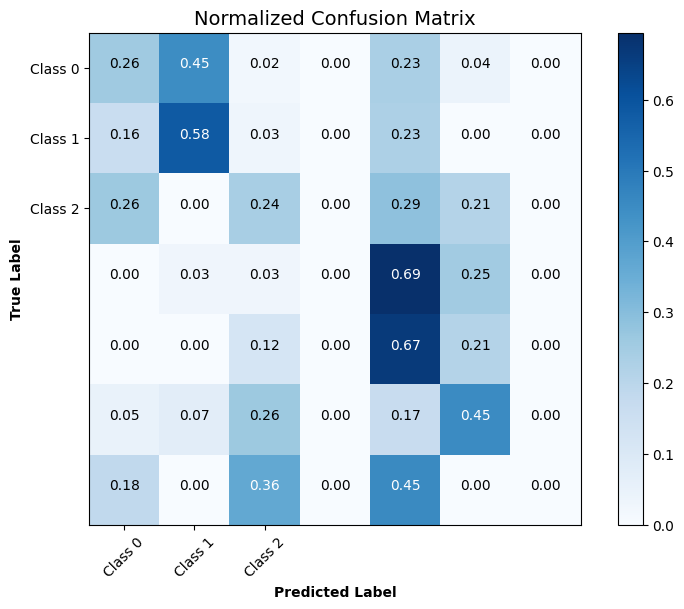

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix


y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True Label", fontweight="bold")
    plt.xlabel("Predicted Label", fontweight="bold")


class_names = ["Class 0", "Class 1", "Class 2"]
plot_confusion_matrix(cm, classes=class_names, normalize=True, title="Normalized Confusion Matrix")
plt.show()
